In [9]:
import tensorflow as tf
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import glob 

import matplotlib.pyplot as plt
from matplotlib import pyplot

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical


train_dir = '/Users/savitaupadhyay/Desktop/Project/trainData'
test_dir = '/Users/savitaupadhyay/Desktop/Project/testData'



In [2]:
def image_data(train_dir, test_dir):
    
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      validation_split=0.2,
      subset="training",
      image_size=(256, 256),
      seed=1,
      batch_size=32,
     labels='inferred',
     label_mode='categorical',
     color_mode='rgb',
    )

    val_data = tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      validation_split=0.2,
      subset="validation",
      seed=1,
      image_size=(256, 256),
      batch_size=32,
      labels='inferred',
      label_mode='categorical',
      color_mode='rgb',
    )

    test_data = tf.keras.preprocessing.image_dataset_from_directory(
      test_dir,
      seed=1,
      image_size=(256, 256),
      batch_size=32,
      labels='inferred',
      label_mode='categorical',
      color_mode='rgb'
    )
    return train_data, val_data, test_data

In [3]:

def get_list_of_files(train_dir, test_dir):
    image_files = []
    train_images = glob.glob("{}/*/*.png".format(train_dir))
    test_images = glob.glob("{}/*/*.png".format(test_dir))
    
    return train_images, test_images

def image_to_vector(image: np.ndarray, scale: bool = False) -> np.ndarray:
    length, height, depth = image.shape
    
    if scale:
        image.reshape((1, length * height * depth))/255.0
        
    return image.reshape((1, length * height * depth))

def read_data(image_files, scale: bool = False, duplicate_limit:int = 5, flag_flatten = False):
    image_array = []
    labels = []
    for image_file in image_files:
        im = cv2.imread(image_file)
        
        if (flag_flatten):
            im = image_to_vector(im, scale)

        # Reshape training and testing image
        if (flag_flatten==False):
            im = im.reshape(-1, 256, 256, 3)
            

        image_array.append(im)        
        labels.append(image_file.split('/')[-2])

                

        if image_file.split('/')[-2] == 'severe':
            for i in range(duplicate_limit):
                image_array.append(im)
                labels.append(image_file.split('/')[-2])  


            
    image_array = np.vstack(image_array)
    
    return image_array, labels





In [4]:


def train_dnn(train_data, test_data, y_train, y_test):
    n_features = train_data.shape[1]

    model = Sequential()
    model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    # model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(train_data, y_train, epochs=15, batch_size=64, verbose=1, 
                        validation_split=0.3, 
                        # callbacks=[es]
                       )

    model.summary()

    loss, acc = model.evaluate(test_data, y_test, verbose=1)
    print('Test Accuracy: %.3f' % acc)

    # plot learning curves
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Cross Entropy')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()
    
    return model


def train_cnn(train_data, val_data, test_data, n_classes=5):    
    # define model
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(256, 256, 3)))
    model.add(MaxPool2D((2, 2)))    
    
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(256, 256, 3)))
    model.add(MaxPool2D((2, 2)))    
    model.add(Flatten()) 
    
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    # model.add(Dropout(0.25))
    
    model.add(Dense(n_classes, activation='softmax'))
    
    # define loss and optimizer
    #sparse_categorical_crossentropy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # fit the model
    history = model.fit(train_data, epochs=10, validation_data=val_data, shuffle=True)
    model.summary()    
        
    # evaluate the model
    loss, acc = model.evaluate(test_data, verbose=1)
    print('Accuracy: %.3f' % acc)    
    
    # plot learning curves
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Cross Entropy')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()
    
    return model


def train_cnn_numpy(train_data, y_train, test_data, y_test, n_classes=5):    
    # define model
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(256, 256, 3)))
    model.add(MaxPool2D((2, 2)))    
    
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(256, 256, 3)))
    model.add(MaxPool2D((2, 2)))    
    model.add(Flatten()) 
    
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    # model.add(Dropout(0.25))
    
    model.add(Dense(n_classes, activation='softmax'))
    
    # define loss and optimizer
    #sparse_categorical_crossentropy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # fit the model
    history = model.fit(train_data, y_train,  epochs=10, validation_split=0.3, shuffle=True)
    model.summary()    
        
    # evaluate the model
    loss, acc = model.evaluate(test_data, y_test, verbose=1)
    print('Accuracy: %.3f' % acc)    
    
    # plot learning curves
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Cross Entropy')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()
    
    return model



### Train Regular  CNN

In [ ]:
train_img_data, val_img_data, test_img_data = image_data(train_dir, test_dir)

In [ ]:
# cnn_model = train_cnn(train_img_data, val_img_data, test_img_data)
cnn_model = train_cnn(train_img_data, val_img_data, test_img_data)


In [ ]:
def predict_cnn(test_img_data):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    for image_batch, label_batch in test_img_data:   # use dataset.unbatch() with repeat
       # append true labels
       y_true.append(label_batch)
       # compute predictions
       preds = cnn_model.predict(image_batch)
       # append predicted labels
       y_pred.append(np.argmax(preds, axis = - 1))

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)        
    
    print(classification_report(np.argmax(correct_labels.numpy(), axis=1), 
                                predicted_labels.numpy(), 
                                target_names=test_img_data.class_names))
    return predicted_categories, y_pred, test_labels

In [ ]:
predict_cnn(val_img_data)
predict_cnn(test_img_data)

In [ ]:
# predict_cnn(val_img_data)
predicted_categories, y_pred, test_labels = predict_cnn(val_img_data)
predicted_categories, y_pred, test_labels = predict_cnn(test_img_data)

### Train DNN

In [ ]:
im = cv2.imread(train_files[0])
im_reshaped = image_to_vector(im)
pyplot.imshow(im, cmap=pyplot.get_cmap('gray'))


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical


train_files, test_files = get_list_of_files(train_dir, test_dir)

# Shuffle before calling Train
np.random.shuffle(train_files)
train_data, train_labels = read_data(train_files, scale=True)

test_data, test_labels = read_data(test_files)

enc = LabelEncoder().fit(train_labels)
y_train = enc.transform(train_labels)
y_train = to_categorical(y_train)

y_test = enc.transform(test_labels)
y_test = to_categorical(y_test)


dnn_model = train_dnn(train_data, test_data, y_train, y_test)

In [ ]:
y_predicted = dnn_model.predict(test_data)
y_predicted = np.argmax(y_predicted, axis=-1)

y_test = enc.transform(test_labels)
y_test = to_categorical(y_test)

y_test = np.argmax(y_test, axis=-1)
print(classification_report(y_test, y_predicted, digits=4))

In [ ]:
def ResNetCNN(train_data, val_data, test_data, n_classes=5):    
    # define model
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(256, 256, 3)))
    model.add(MaxPool2D((2, 2)))    
    
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(256, 256, 3)))
    model.add(MaxPool2D((2, 2)))    
    model.add(Flatten()) 
    
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    # model.add(Dropout(0.25))
    
    model.add(Dense(n_classes, activation='softmax'))
    
    # define loss and optimizer
    #sparse_categorical_crossentropy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # fit the model
    history = model.fit(train_data, epochs=10, validation_data=val_data, shuffle=True)
    model.summary()    
        
    # evaluate the model
    loss, acc = model.evaluate(test_data, verbose=1)
    print('Accuracy: %.3f' % acc)    
    
    # plot learning curves
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Cross Entropy')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()
    
    return model



## CNN: Data augmentation

In [5]:
train_files, test_files = get_list_of_files(train_dir, test_dir)

# Shuffle before calling Train
np.random.shuffle(train_files)
train_data, train_labels = read_data(train_files)

test_data, test_labels = read_data(test_files)

enc = LabelEncoder().fit(train_labels)
y_train = enc.transform(train_labels)
y_train = to_categorical(y_train)

y_test = enc.transform(test_labels)
y_test = to_categorical(y_test)






In [6]:
test_data.shape

(735, 256, 256, 3)

2022-06-10 18:07:48.787421: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-10 18:07:48.788333: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 2075 samples, validate on 890 samples
Epoch 1/10
2075/2075 [==============================] - 365s 176ms/sample - loss: 2535.1252 - accuracy: 0.4414 - val_loss: 1.7582 - val_accuracy: 0.5270
Epoch 2/10
2075/2075 [==============================] - 381s 183ms/sample - loss: 1.3222 - accuracy: 0.5961 - val_loss: 1.2962 - val_accuracy: 0.5191
Epoch 3/10
2075/2075 [==============================] - 363s 175ms/sample - loss: 0.9575 - accuracy: 0.6665 - val_loss: 1.3788 - val_accuracy: 0.5461
Epoch 4/10
2075/2075 [==============================] - 346s 167ms/sample - loss: 0.8261 - accuracy: 0.7060 - val_loss: 1.5439 - val_accuracy: 0.5461
Epoch 5/10
2075/2075 [==============================] - 344s 166ms/sample - loss: 0.6677 - accuracy: 0.7533 - val_loss: 1.7229 - val_accuracy: 0.5483
Epoch 6/10
2075/2075 [==============================] - 346s 167ms/sample - loss: 0.6108 - accuracy: 0.7740 - val_loss: 1.7407 - val_accuracy: 0.5494
Epoch 7/10
2075/2075 [============================

Accuracy: 0.543


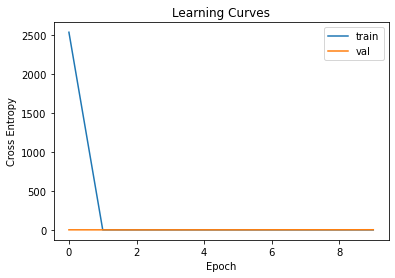

In [7]:
cnn_model = train_cnn_numpy(train_data, y_train, test_data, y_test)

In [8]:
y_predicted = cnn_model.predict(test_data.astype(float))
y_predicted = np.argmax(y_predicted, axis=-1)

y_test = enc.transform(test_labels)
y_test = to_categorical(y_test)

y_test = np.argmax(y_test, axis=-1)
print(classification_report(y_test, y_predicted, digits=4, 
                            target_names=['healthy','mild', 'moderate', 'proliferate', 'severe']))

              precision    recall  f1-score   support

     healthy     0.9375    0.8250    0.8777       200
        mild     0.2706    0.3108    0.2893        74
    moderate     0.4545    0.5278    0.4884       180
 proliferate     0.2000    0.1509    0.1720        53
      severe     0.4800    0.4737    0.4768       228

    accuracy                         0.5429       735
   macro avg     0.4685    0.4576    0.4609       735
weighted avg     0.5570    0.5429    0.5479       735



In [10]:
confusion_matrix(y_test, y_predicted)

array([[165,   1,   5,   2,  27],
       [  6,  23,  22,   4,  19],
       [  4,  14,  95,  14,  53],
       [  1,   5,  21,   8,  18],
       [  0,  42,  66,  12, 108]])

In [ ]:
predicted_categories, y_pred, test_labels = predict_cnn(cnn_model, val_img_data)
predicted_categories, y_pred, test_labels = predict_cnn(cnn_model, test_img_data)